In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{nicefrac}")
plt.rc("font", size=10)

In [5]:
n = 40
ratio = 2**(- n)
sq_one_minus_ratio = np.sqrt(1 - ratio)
sq_ratio = np.sqrt(ratio)

###
l = np.arange(1, np.ceil(np.pi / (4 * sq_ratio)) + 1)
Grover_expected_times = sq_ratio * l / np.square(np.sin((2 * l + 1) * np.arcsin(sq_ratio)))
###

inv_log_step = 10
step = 2**(- inv_log_step)

deltas = np.arange(0.3, 0.7, step)
R = np.arccosh(1 / deltas)
#L0 = np.array(np.ceil(np.arccosh(1 / deltas) / np.arccosh(1 / sq_one_minus_ratio)), dtype=int) >> 1
L0 = np.ceil(R / (2 * np.arccosh(1 / sq_one_minus_ratio)) - 1/2)

queries = np.zeros(deltas.shape[0], dtype=int)

for idx, [delta, r, l0] in enumerate(zip(deltas, R, L0)):
    queries[idx] = np.where(np.cosh(r / (2 * np.arange(l0) + 1)) * sq_one_minus_ratio <= 1)[0][0]

distribution = 1 - np.square(np.cos(np.arccos(np.cosh(np.arccosh(1 / deltas) / (2 * queries + 1)) * sq_one_minus_ratio) * (2 * queries + 1))  * deltas)

expected_times = sq_ratio * queries / distribution

i0 = np.argmin(expected_times)
delta_min, expected_times_min = deltas[i0], expected_times[i0]
print(f"{delta_min:.4}, {expected_times_min:.4}, {(sq_ratio * np.ceil(np.pi / (4 * sq_ratio))):.4}, {(min(Grover_expected_times)):.4}")

0.6047, 0.8581, 0.7854, 0.69


In [6]:
expected_times_min / min(Grover_expected_times), 2.25 / min(Grover_expected_times)

(np.float64(1.243639784279946), np.float64(3.2607537599789023))

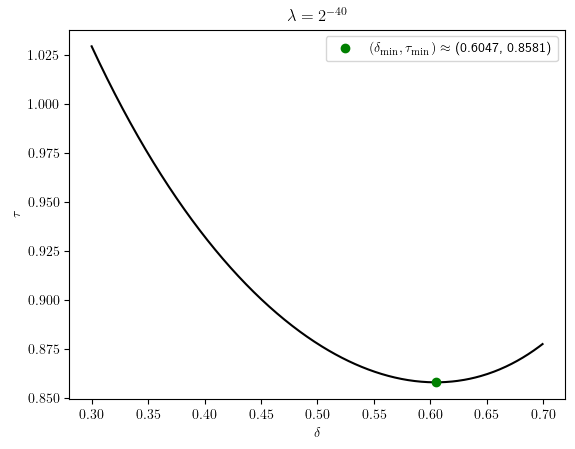

In [7]:
cut_off = 5

plt.title(r"$\lambda = 2^{-40}$")
plt.xlabel(r"$\delta$")
plt.ylabel(r"$\tau$")
plt.plot(deltas[expected_times < cut_off], expected_times[expected_times < cut_off], color = "black")
plt.plot(delta_min, expected_times_min, "go", label = r"$\left( \delta_{\min}, \tau_{\min} \right) \approx$" + f" ({delta_min:.4}, {expected_times_min:.4})")
plt.legend()
plt.show()

In [10]:
log_delta_test = 9
log_alpha_test = 17
n = 40

delta_test = 2**log_delta_test
alpha_test = 2**log_alpha_test
ratio = 2**(- n)
sq_one_minus_ratio = np.sqrt(1 - ratio)
sq_ratio = np.sqrt(ratio)

delta_range = np.linspace(0.3, 0.6, num = delta_test)
alpha_range = np.linspace(1.1, 2, num = alpha_test)

R = np.arccosh(1 / delta_range)
critical_queries = np.zeros(delta_range.shape[0], dtype=int)
for idx, [delta, r, l0] in enumerate(zip(delta_range, R, np.ceil(R / (2 * np.arccosh(1 / sq_one_minus_ratio)) - 1/2))):
    critical_queries[idx] = np.where(np.cosh(r / (2 * np.arange(l0 + 1) + 1)) * sq_one_minus_ratio <= 1)[0][0]



expected_times = np.zeros((delta_range.shape[0], alpha_range.shape[0]))

In [11]:
for i, [delta, r, l0] in enumerate(zip(delta_range, R, critical_queries)):
    S0 = np.floor(np.log(l0) / np.log(alpha_range)) + 1
    for j, [alpha, s0] in enumerate(zip(alpha_range, S0)):
        if alpha * (delta**2) < 1:
            queries = np.unique(np.ceil(np.power(alpha, np.arange(s0))))
            queries = queries[queries < l0]
            P_fail = np.cumprod(np.square(np.cosh(np.arccosh(np.cosh(r / (2 * queries + 1)) * sq_one_minus_ratio) * (2 * queries + 1)) * delta))

            expected_times[i, j] = np.dot(queries[1:], P_fail[:-1]) # terms before the stable range / exact
            expected_times[i, j] += P_fail[-1] * queries[-1] * alpha / (1 - alpha * np.square(delta)) # rest of the stable range / approximate
            expected_times[i, j] *= sq_ratio

            #l = queries[-1] * alpha

            #if np.cosh(r / (2 * np.ceil(l) + 1)) * sq_one_minus_ratio > 1: # making sure
            #    print(delta, alpha)

            #p = np.square(np.sin((2 * np.ceil(l) + 1) * np.arcsin(sq_one_minus_ratio * np.cosh(r / (2 * np.ceil(l) + 1)))) * delta)
            #expected_times[i, j] += P_fail[-1] * l * (1 + p / (np.reciprocal(alpha) - np.square(delta))) # rest of the stable range / approximate
            #expected_times[i, j] *= sq_ratio
        else:
            expected_times[i, j] = np.inf

i0, j0 = np.unravel_index(expected_times.argmin(), expected_times.shape)

delta_opt, alpha_opt, ET_min = delta_range[i0], alpha_range[j0], expected_times[i0, j0]

ET_old = 9 * np.sqrt(ratio) / (2 * np.sin(2 * np.arcsin(sq_ratio))) # -> 9 / 4

print(f"delta_opt\t= {delta_opt:.4}\nalpha_opt\t= {alpha_opt:.4}\nET_min\t\t= {ET_min:.4}\nspeedup\t\t= {(ET_min / ET_old):.2%}\nslowdown\t= {(ET_min / min(Grover_expected_times)):.4%}")

delta_opt	= 0.4022
alpha_opt	= 1.975
ET_min		= 1.433
speedup		= 63.68%
slowdown	= 207.6478%


In [12]:
i1, j1 = np.unravel_index(expected_times[:, alpha_range < alpha_opt * 0.999].argmin(), expected_times[:, alpha_range < alpha_opt * 0.999].shape)
print(f"{delta_range[i1]:.4}, {alpha_range[j1]:.4}, {expected_times[i1, j1]:.4}\t{ET_min:.4}\t{(expected_times[i1, j1] / ET_min - 1):.5%}")

0.4157, 1.91, 1.434	1.433	0.08107%


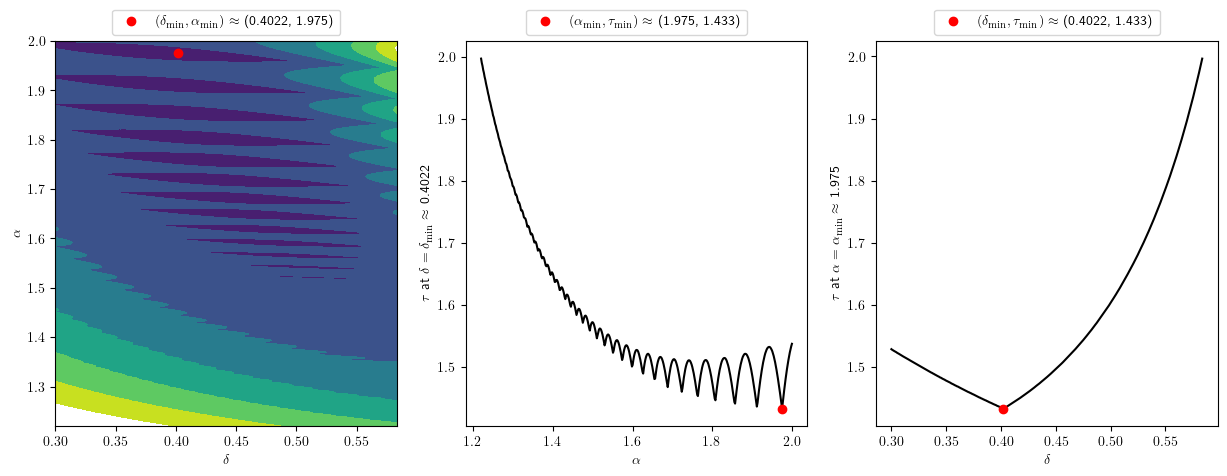

In [15]:
cut_off = 2

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(15, 5))

#fig.suptitle(f"phase portrait of the expected time of success at " + r"$\lambda = 2^{-40}$",  y=1.1, fontsize=30)

axs[0].contourf(delta_range[expected_times[:, j0] < cut_off], alpha_range[expected_times[i0] < cut_off], expected_times.T[np.ix_(expected_times[i0] < cut_off, expected_times[:, j0] < cut_off)], levels=np.round(np.arange(np.floor(ET_min*10) / 10, cut_off, 0.1), 1))
axs[0].set(xlabel=r"$\delta$",
            ylabel=r"$\alpha$")
axs[0].plot(delta_opt, alpha_opt, "ro", label = r"$\left( \delta_{\min},\alpha_{\min} \right) \approx$" + f" ({delta_opt:.4}, {alpha_opt:.4})")
#axs[0].plot(delta_range[i1], alpha_range[j1], "yo", label = r"$\left( \delta_{\min^*}, \alpha_{\min^*} \right) \approx$" + f" ({delta_range[i1]:.4}, {alpha_range[j1]:.4})")
axs[0].legend(bbox_to_anchor = (0.5, 1.1), loc = "upper center")

axs[1].plot(alpha_range[expected_times[i0] < cut_off],
            expected_times[i0][expected_times[i0] < cut_off],
            color="black")
axs[1].plot(alpha_opt, ET_min, "ro", label = r"$\left( \alpha_{\min}, \tau_{\min} \right) \approx$" + f" ({alpha_opt:.4}, {ET_min:.4})")
axs[1].set(xlabel=r"$\alpha$",
            ylabel=r"$\tau$" + f" at " + r"$\delta = \delta_{\min} \approx$" + f" {delta_opt:.4}")
axs[1].legend(bbox_to_anchor = (0.5, 1.1), loc = "upper center")

axs[2].plot(delta_range[expected_times[:, j0] < cut_off],
            expected_times[:, j0][expected_times[:, j0] < cut_off],
            color="black")
axs[2].plot(delta_opt, ET_min, "ro", label = r"$\left( \delta_{\min}, \tau_{\min} \right) \approx$" + f" ({delta_opt:.4}, {ET_min:.4})")
axs[2].set(xlabel=r"$\delta$",
            ylabel=r"$\tau$" + f" at " + r"$\alpha = \alpha_{\min} \approx$" + f" {alpha_opt:.4}")
axs[2].legend(bbox_to_anchor = (0.5, 1.1), loc = "upper center")

plt.show()

In [192]:
radius = 3
a, b = expected_times.shape
loc_mins = []
for i in range(radius, a - radius):
    for j in range(radius, b - radius):
        if expected_times[i, j] < np.inf and expected_times[i, j] == np.min(expected_times[np.ix_(np.arange(i - radius, i + radius + 1), np.arange(j - radius, j + radius + 1))]):
            loc_mins.append([i, j])

In [193]:
for [i, j] in sorted(loc_mins, key=lambda x: expected_times[x[0]][x[1]]):
    if alpha_opt > alpha_range[j]:
        print(f"{(1 - alpha_range[j] / alpha_opt):.4}\t\t{(expected_times[i, j] / ET_min - 1):.4%}")

0.03957		0.2475%
0.03957		0.2494%
0.03957		0.2515%
0.03957		0.2524%
0.03957		0.2874%
0.07414		0.8621%
0.0746		1.1330%
0.0746		1.1391%
0.0746		1.1607%
0.0746		1.1692%
0.0746		1.1896%
0.0746		1.1997%
0.0746		1.2205%
0.0746		1.2329%
0.0746		1.2542%
0.07369		1.5412%
0.1042		2.3701%
0.1046		2.4436%
0.1037		2.5094%
0.1046		2.5127%
0.1037		2.6420%
0.07323		2.6476%
0.1051		2.8133%
0.1051		2.9699%
0.1051		2.9790%
0.1033		3.5571%
0.1055		3.6352%
0.1055		3.6390%
0.1055		3.6446%
0.1055		3.6491%
0.1055		3.6522%
0.1055		3.6593%
0.1055		3.6621%
0.1055		3.6639%
0.1055		3.6801%
0.1055		3.6909%
0.1055		3.6927%
0.1305		3.8997%
0.131		3.9006%
0.1301		4.0374%
0.1315		4.0624%
0.1301		4.1327%
0.1315		4.1766%
0.1315		4.2174%
0.1296		4.2881%
0.1319		4.4690%
0.1319		4.5131%
0.1319		4.5449%
0.1319		4.5778%
0.106		4.9858%
0.106		5.0141%
0.106		5.0259%
0.106		5.0596%
0.106		5.0733%
0.1324		5.1657%
0.1324		5.1795%
0.1324		5.1830%
0.1324		5.1967%
0.1324		5.1999%
0.1324		5.2201%
0.1324		5.2209%
0.1324		5.2370%
0.1324

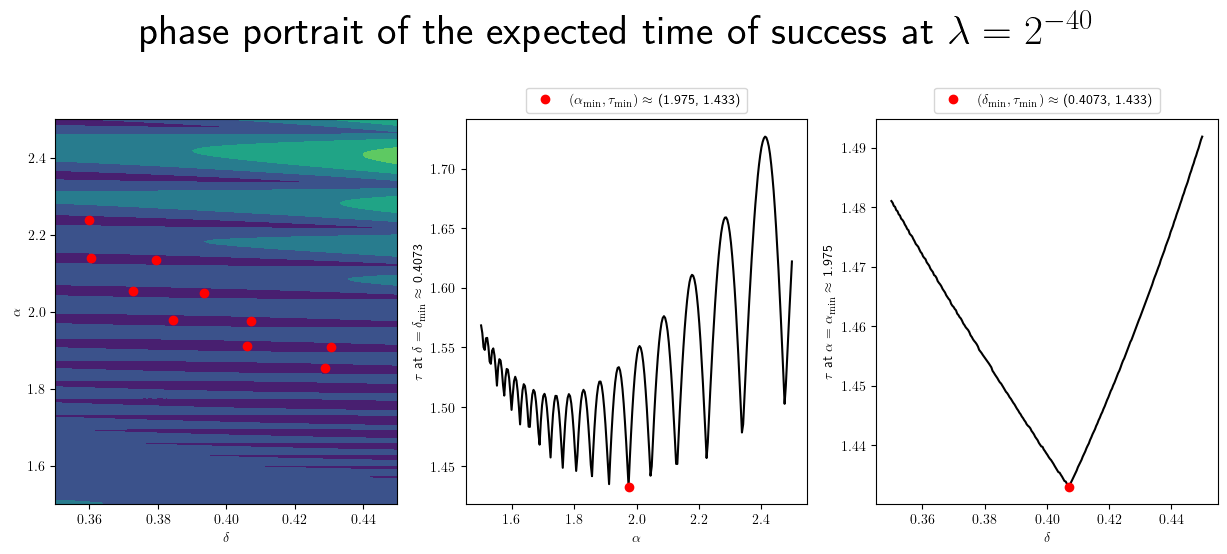

In [89]:
cut_off = 2

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(15, 5))

fig.suptitle(f"phase portrait of the expected time of success at " + r"$\lambda = 2^{-40}$",  y=1.1, fontsize=30)

axs[0].contourf(delta_range[expected_times[:, j0] < cut_off], alpha_range[expected_times[i0] < cut_off], expected_times.T[np.ix_(expected_times[i0] < cut_off, expected_times[:, j0] < cut_off)], levels=np.round(np.arange(1.4, cut_off, 0.1), 1))
axs[0].set(xlabel=r"$\delta$",
            ylabel=r"$\alpha$")
for i, j in sorted(loc_mins, key=lambda x: expected_times[x[0]][x[1]])[:10]:
    axs[0].plot(delta_range[i], alpha_range[j], "ro")
#axs[0].legend(bbox_to_anchor = (0.5, 1.15), loc = "upper center")

axs[1].plot(alpha_range[expected_times[i0] < cut_off],
            expected_times[i0][expected_times[i0] < cut_off],
            color="black")
axs[1].plot(alpha_opt, ET_min, "ro", label = r"$\left( \alpha_{\min}, \tau_{\min} \right) \approx$" + f" ({alpha_opt:.4}, {ET_min:.4})")
axs[1].set(xlabel=r"$\alpha$",
            ylabel=r"$\tau$" + f" at " + r"$\delta = \delta_{\min} \approx$" + f" {delta_opt:.4}")
axs[1].legend(bbox_to_anchor = (0.5, 1.1), loc = "upper center")

axs[2].plot(delta_range[expected_times[:, j0] < cut_off],
            expected_times[:, j0][expected_times[:, j0] < cut_off],
            color="black")
axs[2].plot(delta_opt, ET_min, "ro", label = r"$\left( \delta_{\min}, \tau_{\min} \right) \approx$" + f" ({delta_opt:.4}, {ET_min:.4})")
axs[2].set(xlabel=r"$\delta$",
            ylabel=r"$\tau$" + f" at " + r"$\alpha = \alpha_{\min} \approx$" + f" {alpha_opt:.4}")
axs[2].legend(bbox_to_anchor = (0.5, 1.1), loc = "upper center")

plt.show()

In [60]:
a, b = 6, 6
A = np.arange(a * b).reshape(a, b)
A

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [67]:
radius = 2
i, j = 2, 2
print(A[i, j])
print(A)

14
[[ 0  1  2  3  4]
 [ 6  7  8  9 10]
 [12 13 14 15 16]
 [18 19 20 21 22]
 [24 25 26 27 28]]


In [14]:
9 / (2 * 1.433)

3.14026517794836

In [15]:
np.pi

3.141592653589793